### 프로젝트: 뉴스기사 요약해보기

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Step 1. 데이터 수집하기


In [39]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.sample(10)

,headlines,text
90570,Tripathi's 93 helps RPS rise to third spot in ...,Rising Pune Supergiant defeated Kolkata Knight...
87714,Celina Jaitly pregnant with twins again,"Actress Celina Jaitly, who is a mother to five..."
32679,We did not encourage crime: SC refuses stay on...,Refusing the Centre's petition to stay its Mar...
71968,"Delhi man arrested for sex assault, murder of ...",The Delhi Police has arrested a 40-year-old ma...
65421,Complete lack of interest by CBI in Najeeb Ahm...,The Delhi High Court on Monday slammed the CBI...
50624,'Plastic road-maker' Rajagopalan Vasudevan win...,"Rajagopalan Vasudevan, dubbed 'plastic road-ma..."
13307,WhatsApp India not complying with payment data...,Days after WhatsApp announced a local system t...
55164,US terrified by our nuclear force: North Korea,Following the UN Security Council decision to ...
4853,"Ranveer to play Dara Shikoh, Vicky to play Aur...",Actors Ranveer Singh and Vicky Kaushal have re...
7003,"23-year-old tries to settle fight, gets killed...",A 23-year-old man in Pune was allegedly killed...


#### Step 2. 데이터 전처리하기 (추상적 요약)

In [40]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280
전체 샘플수 : 98360


In [41]:
print(data.isnull().sum())

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

headlines    0
text         0
dtype: int64
전체 샘플수 : 98360


In [42]:
# 텍스트 정규화와 불용어 제거

from nltk.corpus import stopwords

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

정규화 사전의 수:  120
불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', '

In [43]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [44]:
# Text를 전처리하고, 결과를 확인하기 위해 상위 5개 출력

clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [45]:
# Summary 전처리 시에는 불용어 제거를 'False'로 지정

clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [46]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [47]:
# 빈 샘플을 확인후 제거하기

print(data.isnull().sum())

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

headlines    0
text         0
Text         0
Summary      0
dtype: int64
전체 샘플수 : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


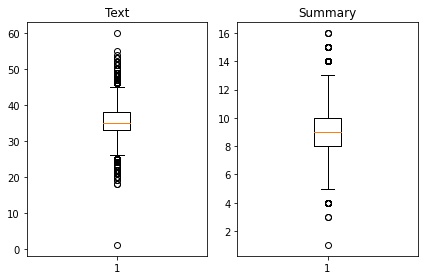

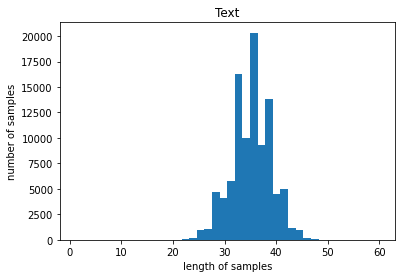

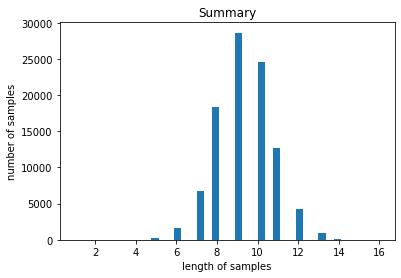

In [48]:
### 훈련데이터와 테스트데이터 나누기

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [49]:
text_max_len = 50
summary_max_len = 12

In [50]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [51]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [52]:
# 정해진 길이보다 길면 제외하기

data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 97169


In [53]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,Text,Summary,decoder_input,decoder_target
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [54]:
# 인코더의 입력, 디코더의 입력 & 레이블을 다시 Numpy 타입으로 저장하기

encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [55]:
# 훈련/테스트 데이터 분리

## encoder_input과 크기/형태가 같은 순서가 섞인 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

## 만든 정수 시퀀스를 이용해 데이터의 샘플 순서를 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

## 데이터를 8:2 비율로 분리. 전체 데이터 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정한다.
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

## 정의한 테스트 데이터 개수를 이용해 전체 데이터를 split.
## : 표시의 위치에 주의!!

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

[ 5756 43075 70952 ... 30842 50139 51749]
=3
테스트 데이터의 수 : 19433
훈련 데이터의 개수 : 77736
훈련 레이블의 개수 : 77736
테스트 데이터의 개수 : 19433
테스트 레이블의 개수 : 19433


In [56]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [57]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69190
등장 빈도가 6번 이하인 희귀 단어의 수: 47118
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22072
단어 집합에서 희귀 단어의 비율: 68.09943633473046
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.502952960031893


In [58]:

src_vocab = 16000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 16,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [59]:
# texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 단어들을 모두 정수로 변환한다(정수인코딩).

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2544, 48, 1, 1015, 14, 2256, 3852, 12152, 126, 6434, 1105, 269, 1072, 650, 2486, 20, 425, 1398, 641, 882, 429, 2768, 429, 312, 1900, 831, 3084, 1156, 2544, 1], [3, 13, 38, 338, 88, 2525, 67, 52, 617, 10219, 3214, 64, 154, 5786, 972, 133, 9, 1, 44, 24, 1194, 835, 3995, 752, 52, 491, 3672, 3879, 142, 258, 177, 666, 934, 3718, 369], [567, 2425, 989, 108, 5609, 131, 458, 252, 367, 1809, 131, 458, 1, 567, 7, 246, 1568, 989, 458, 252, 1380, 91, 345, 989, 252, 567, 893, 2356, 989, 989, 1665, 625, 110, 118, 990]]


In [60]:
# Summary 데이터에 대해서도 동일한 작업 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')


# tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있다. 
# 이를 통해 등장 빈도수가 5회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

=3
단어 집합(vocabulary)의 크기 : 30025
등장 빈도가 4번 이하인 희귀 단어의 수: 18480
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11545
단어 집합에서 희귀 단어의 비율: 61.54870940882597
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.9805719288958685


In [61]:
# 이전과 동일하게, 등장 빈도가 4회 이하인 단어들을 제거한다.
# 어림잡아 8000을 단어 집합의 크기로 제한한다.

tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1834, 56, 19, 115, 4000, 7222, 4, 1435], [1, 389, 20, 4806, 63, 17, 3458, 16, 38, 7, 318], [1, 253, 496, 173, 5385, 794, 697, 559], [1, 1546, 1835, 3378, 81, 4, 26], [1, 141, 1296, 2058, 2426, 4, 347, 639, 1407, 89]]
target
decoder  [[1834, 56, 19, 115, 4000, 7222, 4, 1435, 2], [389, 20, 4806, 63, 17, 3458, 16, 38, 7, 318, 2], [253, 496, 173, 5385, 794, 697, 559, 2], [1546, 1835, 3378, 81, 4, 26, 2], [141, 1296, 2058, 2426, 4, 347, 639, 1407, 89, 2]]


In [62]:
# 길이가 1인 요약문 삭제

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77735
훈련 레이블의 개수 : 77735
테스트 데이터의 개수 : 19433
테스트 레이블의 개수 : 19433


In [63]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


#### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [64]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [65]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [66]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 128)      2048000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 50, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [67]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 128)      2048000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 50, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [68]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
304/304 [==============================] - 227s 720ms/step - loss: 5.4296 - val_loss: 5.0149
Epoch 2/50
304/304 [==============================] - 226s 744ms/step - loss: 4.8446 - val_loss: 4.6497
Epoch 3/50
304/304 [==============================] - 248s 816ms/step - loss: 4.5269 - val_loss: 4.3842
Epoch 4/50
304/304 [==============================] - 248s 817ms/step - loss: 4.2694 - val_loss: 4.1776
Epoch 5/50
304/304 [==============================] - 250s 823ms/step - loss: 4.0637 - val_loss: 4.0451
Epoch 6/50
304/304 [==============================] - 248s 816ms/step - loss: 3.8996 - val_loss: 3.9373
Epoch 7/50
 12/304 [>.............................] - ETA: 3:43 - loss: 3.7554

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)


In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

#### Step 5. Summa을 이용해서 추출적 요약해보기

In [ ]:
import requests
from summa.summarizer import summarize

In [ ]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [ ]:
print(text[:1500])

In [ ]:
print('Summary:')
print(summarize(text, ratio=0.005))

In [ ]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

In [ ]:
print('Summary:')
print(summarize(text, words=50))